<a href="https://colab.research.google.com/github/dobrinaVI/Customer-Churn-Prediction-using-XGBOOST/blob/main/Customer_Churn_Prediction_using_XGBOOST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer churn prediction using XGBoost

Using XGBoost to build a collection of boosted trees. Utilizing continuous and categorical customer data from the Telco Churn Dataset (IBM Base Samples) to predict whether or not a customer will stop using the company's survice.

In [ ]:
#Install libraries as needed
!pip install pandas-profiling

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import graphviz as gv
import matplotlib.pyplot as plt

#from pandas_profiling import ProfileReport
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, recall_score, precision_score
from sklearn.feature_selection import SelectKBest,chi2,mutual_info_classif
from imblearn.over_sampling import SMOTE

## 1. Data import and profiling

### 1.1 EDA (Exploratory data analisys)

In [ ]:
# Load the data
data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [ ]:
# Generate the Telco Churn Data profiling report
profile = data.profile_report(title='Telco Churn Profiling Report')
profile.to_file(output_file="Telco-Churn-Profiling-Report.html")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

The Telco Churn dataset contains 21 variables and 7043 observations with no duplicates or missing cells at first glance. Also, categorical variables seem to contain only the expected values.

Variables summary and closer look:
* customerID - irrelevant for the analisys - *to be dropped*.

Demographics:
* gender (Categorical) - equally distributed
* SeniorCitizen (Categorical) - most customers are not senior citizens (83,8%)
* Partner: Indicates whether the customer has a partner (Yes) or not (No). Equally distributed
* Dependents (Categorical) - olny 30% of the customers are dependants

Subscription-related:
* tenure (Continuous) - defined as Number of months the customer has stayed with the company with mean of 32. Also contains zeros (0.2%), which probably identidy new cusomers.
* PhoneService (Categorical) - defined as Whether the customer has a phone service or not (Yes, No). Most customers (90.3%) have phone service.
* MultipleLines (Categorical) - defined as Whether the customer has multiple lines or not (Yes, No, No phone service). Equally distributed for customers with phone service. In this context "No phone service" has the same meaning as "No".
* InternetService (Categorical) - Customer’s internet service provider (DSL, Fiber optic, No). Mostly Fiber optic (44%)

Options, related to internet service - (Yes, No, No internet service). In this context "No internet service" has the same meaning as "No":
* OnlineSecurity (Categorical) - Mostly No (49%)
* OnlineBackup (Categorical) - Mostly No (43.8%)
* DeviceProtection (Categorical) - Mostly No (43.9%)
* TechSupport (Categorical) - Mostly No (49.3%)
* StreamingTV (Categorical) - Mostly No (39.9%)
* StreamingMovies (Categorical) - Mostly No (39.9%)

Contract-related:
* Contract (Categorical)  - Mostly Month-to-month (55%)
* PaperlessBilling (Categorical) - Mostly paperless (59.2%)
* PaymentMethod - all payments types are used (electronic check, mailed check, bank transfer (automatic), credit card (automatic)), with electronic check splightly more common (33.6%)
* MonthlyCharges (Continuous) - most customers pay ~\$20, with a mean of $65.
* TotalCharges (Categorical) - *should be continuous*
* Churn - 26.5% of customers are lost. *This should be taken into account when training and evaluating the model.*

### 1.2 Features preparation

In [ ]:
# Drop unnecessary column customer ID
data.drop('customerID', axis=1, inplace=True)

In [ ]:
## Convert TotalCharges to continuous - an error encountered "could not convert
## string to float: ' '", meaning that there are empty values, which need to be fixed
data['TotalCharges'] = data['TotalCharges'].replace(' ', np.nan)
data['TotalCharges'] = data['TotalCharges'].astype(float)
data['TotalCharges'].describe()

count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: TotalCharges, dtype: float64

In [ ]:
# Inspect customers with missing charges
data[data['TotalCharges'].isna()]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


In [ ]:
len(data[data['TotalCharges'].isna()])

11

All 11 customers with missing charges are actually new customers (tenure=0), therefore it is safe to assume that the charge is not missing, but actually 0 (not charged yet).

In [ ]:
# Set TotalCharges to 0, where initially it was empty and make sure it is implemented correctly
data.loc[data['TotalCharges'].isna(),'TotalCharges'] = 0
data.loc[data['TotalCharges']==0]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,0.0,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,0.0,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,0.0,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,0.0,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,0.0,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,0.0,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,0.0,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,0.0,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,0.0,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,0.0,No


In [ ]:
len(data[data['TotalCharges']==0])

11

In [ ]:
# Correct data type for tenure
data['tenure']= data['tenure'].astype(float)

# Correct data type for gender
data['SeniorCitizen']= data['SeniorCitizen'].astype(str)

# Replace the 'No internet/phone service' value with "No"
data[['OnlineSecurity',
      'OnlineBackup',
      'DeviceProtection',
      'TechSupport',
      'StreamingTV',
      'StreamingMovies']]= data[['OnlineSecurity',
                                'OnlineBackup',
                                'DeviceProtection',
                                'TechSupport',
                                'StreamingTV',
                                'StreamingMovies']].replace('No internet service','No')

data[['MultipleLines']]= data[['MultipleLines']].replace('No phone service','No')

In [ ]:
## Some of the columns contain blank spaces in the categorical values, so we
## need to fix that to be able to visualise the tree
data.replace(" ","_", regex=True, inplace=True)
data.head(10)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1.0,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic_check,29.85,29.85,No
1,Male,0,No,No,34.0,Yes,No,DSL,Yes,No,Yes,No,No,No,One_year,No,Mailed_check,56.95,1889.50,No
2,Male,0,No,No,2.0,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15,Yes
3,Male,0,No,No,45.0,No,No,DSL,Yes,No,Yes,Yes,No,No,One_year,No,Bank_transfer_(automatic),42.30,1840.75,No
4,Female,0,No,No,2.0,Yes,No,Fiber_optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65,Yes
5,Female,0,No,No,8.0,Yes,Yes,Fiber_optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic_check,99.65,820.50,Yes
6,Male,0,No,Yes,22.0,Yes,Yes,Fiber_optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit_card_(automatic),89.10,1949.40,No
7,Female,0,No,No,10.0,No,No,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed_check,29.75,301.90,No
8,Female,0,Yes,No,28.0,Yes,Yes,Fiber_optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic_check,104.80,3046.05,Yes
9,Male,0,No,Yes,62.0,Yes,No,DSL,Yes,Yes,No,No,No,No,One_year,No,Bank_transfer_(automatic),56.15,3487.95,No


In [ ]:
    # categorical columns
    cat_cols = [col for col in data.columns if data[col].dtypes == "O"]
    # num_cols
    num_cols = [col for col in data.columns if data[col].dtypes != "O"]

In [ ]:
 cat_cols

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

In [ ]:
num_cols

['tenure', 'MonthlyCharges', 'TotalCharges']

## 2. Format the data for XGBoost

### 2.1 Splitting the dataset into features target variable

In [ ]:
# Splitting the dataset into features (X) and target variable (y)
X = data.drop('Churn', axis=1)
y = data['Churn']

### 2.2 One-Hot Encoding for categorical variables

In [ ]:
X.columns #get a list of the columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges'],
      dtype='object')

In [ ]:
# X_coltypes=pd.DataFrame(X.dtypes,columns=['Type'])
# X_cat=X_coltypes[X_coltypes["Type"]=="object"][0:]
# X_cat

In [ ]:
#One-Hot Encoding for Categorical variables in X
X_encoded = pd.get_dummies(X, columns=['gender', 'SeniorCitizen', 'Partner',
                                       'Dependents', 'PhoneService',
                                       'MultipleLines', 'InternetService',
                                       'OnlineSecurity', 'OnlineBackup',
                                       'DeviceProtection', 'TechSupport',
                                       'StreamingTV', 'StreamingMovies',
                                       'Contract', 'PaperlessBilling',
                                       'PaymentMethod'])
X_encoded.head()

,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One_year,Contract_Two_year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank_transfer_(automatic),PaymentMethod_Credit_card_(automatic),PaymentMethod_Electronic_check,PaymentMethod_Mailed_check
0,1.0,29.85,29.85,1,0,1,0,0,1,1,...,0,1,0,0,0,1,0,0,1,0
1,34.0,56.95,1889.50,0,1,1,0,1,0,1,...,0,0,1,0,1,0,0,0,0,1
2,2.0,53.85,108.15,0,1,1,0,1,0,1,...,0,1,0,0,0,1,0,0,0,1
3,45.0,42.30,1840.75,0,1,1,0,1,0,1,...,0,0,1,0,1,0,1,0,0,0
4,2.0,70.70,151.65,1,0,1,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0


### 2.3. Label encoding for target variable

In [ ]:
# Initialize a LabelEncoder object
encoder = LabelEncoder()

# Fit the encoder on the target variable
encoder.fit(y)

# Transform the target variable using label encoding
y_encoded = encoder.transform(y)

# Print the encoded labels
print(y_encoded[:5])

[0 0 1 0 1]


### 2.4 Split the data into train and testing set
As only 26,5% of the customers left Telco, we need to make sure we maintain the same churn percentage in both the training and testing set.

In [ ]:
# Split the data into train/test
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded,
                                                    random_state=5, #to endure the split is reproducable
                                                    stratify=y_encoded) #stratifying by Churn

In [ ]:
# Verify that the train/test datasets are correctly stratified
print(sum(y_train)/len(y_train))
print(sum(y_test)/len(y_test))

0.2654297614539947
0.26519023282226006


In [ ]:
len(y_test) #length of the test dataset

1761

## 3. Build a Preliminary XGBoost Classifier

* The classifier will be trained for binary classification using logistic regression as the objective function.
* Early stopping is also specified, meaning that if the evaluation metric does not improve for 10 consecutive rounds, the training process will be stopped early to prevent overfitting.
* The evaluation metric used will be AUC-PR (area under the precision-recall curve), as it is particularly useful when dealing with imbalanced datasets. AUC-PR captures the trade-off between precision and recall at different classification thresholds. It considers the ability of the classifier to both identify positive instances correctly (high recall) and minimize false positives (high precision).

In [ ]:
# Create the Churn XGBoost classifier
churn_clf = xgb.XGBClassifier(objective="binary:logistic", seed=5,
                              early_stopping_rounds=10, eval_metric="aucpr")

# Fit the model as specified
churn_clf.fit(X_train, y_train, verbose=True,
              eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.62417
[1]	validation_0-aucpr:0.63862
[2]	validation_0-aucpr:0.64046
[3]	validation_0-aucpr:0.64319
[4]	validation_0-aucpr:0.64637
[5]	validation_0-aucpr:0.64585
[6]	validation_0-aucpr:0.64921
[7]	validation_0-aucpr:0.65404
[8]	validation_0-aucpr:0.66017
[9]	validation_0-aucpr:0.65784
[10]	validation_0-aucpr:0.65955
[11]	validation_0-aucpr:0.65960
[12]	validation_0-aucpr:0.66092
[13]	validation_0-aucpr:0.65991
[14]	validation_0-aucpr:0.66082
[15]	validation_0-aucpr:0.65970
[16]	validation_0-aucpr:0.65917
[17]	validation_0-aucpr:0.65869
[18]	validation_0-aucpr:0.65805
[19]	validation_0-aucpr:0.65632
[20]	validation_0-aucpr:0.65586
[21]	validation_0-aucpr:0.65400


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Evaluate model performance on testing dataset

Running the test data through the model and draw a confusion matrix.

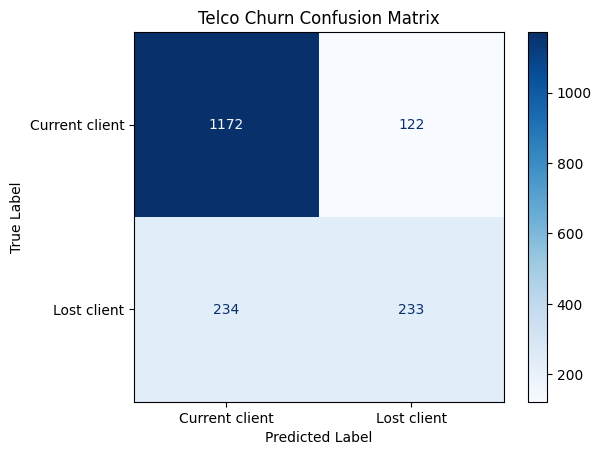

Recall: 0.4989293361884368
Precision: 0.6563380281690141
Specifity: 0.9057187017001546


In [ ]:
# Make predictions on the test set
y_pred = churn_clf.predict(X_test)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a ConfusionMatrixDisplay object
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                 display_labels=["Current client", "Lost client"])

# Plot the confusion matrix
cm_disp.plot(cmap='Blues')

# Add title and axis labels
plt.title('Telco Churn Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()

#print Recall and Precision:
print("Recall:",recall_score(y_test, y_pred))
print("Precision:",precision_score(y_test, y_pred))
print("Specifity:",cm[0, 0]/(cm[0, 0]+cm[0, 1]))

As seen from the confusion matrix, from the current clients, 91% were classified correctly. From the lost clients, however, only  50% were correctly classified. The observed behaviour is typical for imbalanced datasets.
=> model performance should be optimised.

## 6. Optimise model performance using scale_pos_weight parameter

* scale_pos_weight - XGBoost's own hyperparameter for dealing with imbalanced data. It adds a penalty for incorectly classifying the miority class. XGBoost Manual recommends to set it at sum(negative instances)/sum(positive instances) = non-churned customers/churned customers = 5174/1869 = 2.77

In [ ]:
# Create the Churn XGBoost classifier
churn_clf_SPW = xgb.XGBClassifier(objective="binary:logistic", seed=5,
                              early_stopping_rounds=10, eval_metric="aucpr",
                                  scale_pos_weight=2.77)

# Fit the model as specified
churn_clf_SPW.fit(X_train, y_train, verbose=True,
              eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.63098
[1]	validation_0-aucpr:0.63866
[2]	validation_0-aucpr:0.63899
[3]	validation_0-aucpr:0.64255
[4]	validation_0-aucpr:0.64619
[5]	validation_0-aucpr:0.64792
[6]	validation_0-aucpr:0.64633
[7]	validation_0-aucpr:0.64961
[8]	validation_0-aucpr:0.65007
[9]	validation_0-aucpr:0.65076
[10]	validation_0-aucpr:0.65174
[11]	validation_0-aucpr:0.65013
[12]	validation_0-aucpr:0.65057
[13]	validation_0-aucpr:0.65026
[14]	validation_0-aucpr:0.65040
[15]	validation_0-aucpr:0.65096
[16]	validation_0-aucpr:0.64939
[17]	validation_0-aucpr:0.64968
[18]	validation_0-aucpr:0.64973
[19]	validation_0-aucpr:0.64918


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

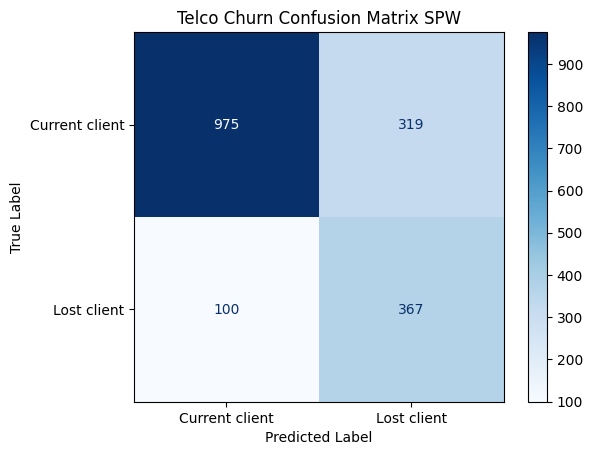

Recall: 0.7858672376873662
Precision: 0.5349854227405247
Specifity: 0.7534775888717156


In [ ]:
# Make predictions on the test set
y_pred = churn_clf_SPW.predict(X_test)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a ConfusionMatrixDisplay object
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                 display_labels=["Current client", "Lost client"])

# Plot the confusion matrix
cm_disp.plot(cmap='Blues')

# Add title and axis labels
plt.title('Telco Churn Confusion Matrix SPW')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()

#print Recall and Precision:
print("Recall:",recall_score(y_test, y_pred))
print("Precision:",precision_score(y_test, y_pred))
print("Specifity:",cm[0, 0]/(cm[0, 0]+cm[0, 1]))


As seen from the confusion matrix, adding the scale_pos_weight parameter alone improved the Recall (prediction of Lost Clients) with ~15%, however this comes at the expence of correctly predicting Current clients.

## 6. Optimise model performance using SMOTE

SMOTE (Synthetic Minority Over-sampling Technique): SMOTE is a machine learning technique used to address the class imbalance problem by generating synthetic examples of the minority class to increase its representation and thus reduce the imbalance between classes.

In [ ]:
smote = SMOTE(sampling_strategy="all", random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
print(sum(y_train_resampled)/len(y_train_resampled))

0.5


In [ ]:
# Create the Churn XGBoost classifier
churn_clf_SMOTE = xgb.XGBClassifier(objective="binary:logistic", seed=5,
                              early_stopping_rounds=10, eval_metric="aucpr")

# Fit the model as specified
churn_clf_SMOTE.fit(X_train_resampled, y_train_resampled, verbose=True,
              eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.57505
[1]	validation_0-aucpr:0.60023
[2]	validation_0-aucpr:0.62710
[3]	validation_0-aucpr:0.61556
[4]	validation_0-aucpr:0.62892
[5]	validation_0-aucpr:0.63185
[6]	validation_0-aucpr:0.63475
[7]	validation_0-aucpr:0.64650
[8]	validation_0-aucpr:0.64974
[9]	validation_0-aucpr:0.64832
[10]	validation_0-aucpr:0.65507
[11]	validation_0-aucpr:0.65462
[12]	validation_0-aucpr:0.65551
[13]	validation_0-aucpr:0.65514
[14]	validation_0-aucpr:0.65211
[15]	validation_0-aucpr:0.65234
[16]	validation_0-aucpr:0.65297
[17]	validation_0-aucpr:0.65244
[18]	validation_0-aucpr:0.64894
[19]	validation_0-aucpr:0.64768
[20]	validation_0-aucpr:0.64761
[21]	validation_0-aucpr:0.64762


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

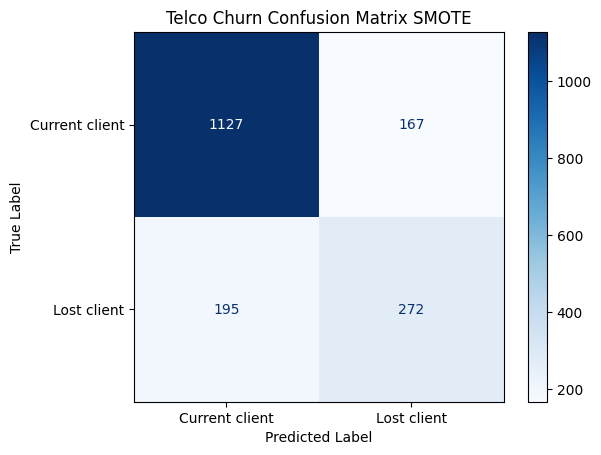

Recall: 0.582441113490364
Precision: 0.6195899772209568
Specifity: 0.8709428129829985


In [ ]:
# Make predictions on the test set
y_pred = churn_clf_SMOTE.predict(X_test)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a ConfusionMatrixDisplay object
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                 display_labels=["Current client", "Lost client"])

# Plot the confusion matrix
cm_disp.plot(cmap='Blues')

# Add title and axis labels
plt.title('Telco Churn Confusion Matrix SMOTE')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()

#print Recall and Precision:
print("Recall:",recall_score(y_test, y_pred))
print("Precision:",precision_score(y_test, y_pred))
print("Specifity:",cm[0, 0]/(cm[0, 0]+cm[0, 1]))

By using the SMOTE technique alone we do not achieve as high recall as with XGBoost's own parameter.

## 5. Optimise model perofrmance by using cross validation and custom scorer

Additional parameters will be added and fine-tuned:

* subsample and colsample_bytree - to prevent overfitting we will randomise the subset of data used and also subset the number of features used per tree.
* max_depth - maximum depth of the tree
* learning_rate - "eta", determines the step size at each boosting iteration
* gamma - pruning parameter, specifies the minimum loss reduction required to make a further partition on a leaf node
* reg_lambda - applies Ridge regularization on the weights to reduce overfitting

RandomizedSearchCV() will be used for the optimisation.

Since We would like to optimise for both Recall and Specifity, we will use  the make_scorer function to create the metric.


In [ ]:
# Create parameters grit to optimise for
param_grid = {
     'scale_pos_weight' :[2.77],
     'max_depth':[3,4,5,7],
     'learning_rate':[0.001,0.01,0.05,0.07,0.1],
     'gamma':[0,0.1,0.2,1,3,5],
     'reg_lambda':[0,0.001, 0.01,0.1,0.5,1],
     'subsample':[0.7,0.8,0.85,0.87,0.9],
     'colsample_bytree':[0.3,0,4,0.5,0.6,0.7,0.8,0.9,0.95,0.98],
     "min_child_weight": [1, 3, 5, 7,10],
     "reg_alpha": [0, 0.001, 0.01]}

In [ ]:
# # define a custom recall/specificity/precision scorer
# def specificity_scoring(y_true, y_pred):
#     tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
#     specificity = tn / (tn+fp)
#     return specificity

# def recall_scoring(y_true, y_pred):
#     recall = recall_score(y_true, y_pred)
#     return recall

# def precision_scoring(y_true, y_pred):
#     recall = precision_score(y_true, y_pred)
#     return recall

In [ ]:
# # Define the scoring metrics
# scoring_metrics = {
#     'recall': make_scorer(recall_scoring),
#     'specificity': make_scorer(specificity_scoring),
#     'precision':make_scorer(precision_scoring)
# }

In [ ]:
# define optimisation problem
optimal_param = RandomizedSearchCV(estimator=churn_clf,
                             param_distributions=param_grid,
                             scoring="f1",
                             verbose=3,
                             n_jobs=100,
                             cv=10)

In [ ]:
optimal_param.fit(X_train, y_train, verbose=3,
                  eval_set=[(X_test, y_test)])

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[0]	validation_0-aucpr:0.61947
[3]	validation_0-aucpr:0.64140
[6]	validation_0-aucpr:0.64451
[9]	validation_0-aucpr:0.64058


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 620, in inner_f
 

[12]	validation_0-aucpr:0.64529
[15]	validation_0-aucpr:0.64926
[18]	validation_0-aucpr:0.64621
[21]	validation_0-aucpr:0.65137
[24]	validation_0-aucpr:0.65099
[27]	validation_0-aucpr:0.65204
[30]	validation_0-aucpr:0.65424
[33]	validation_0-aucpr:0.65740
[36]	validation_0-aucpr:0.65922
[39]	validation_0-aucpr:0.66007
[42]	validation_0-aucpr:0.66249
[45]	validation_0-aucpr:0.66183
[48]	validation_0-aucpr:0.66047
[51]	validation_0-aucpr:0.66202
[52]	validation_0-aucpr:0.66052


RandomizedSearchCV(cv=10,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=10,
                                           enable_categorical=False,
                                           eval_metric='aucpr',
                                           feature_types=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_ra...
                   param_distributions={'colsample_bytree': [0.3, 0, 4, 0.5,
                                                             0.6, 0.7, 0.8, 0.9,
                                                             0.95, 0.98],
                                        'gamma': [0, 0.1, 0.2, 1, 3, 5],
                                        'learning_rate': [0.001, 0.01, 0.05,
                                                          0.07, 0.1],
                                        'max_depth': [3, 4, 5, 7],
                                        'min_child_weight': [1, 3, 5, 7, 10],
                                        'reg_alpha': [0, 0.001, 0.01],
                                        'reg_lambda': [0, 0.001, 0.01, 0.1, 0.5,
                                                       1],
                                        'scale_pos_weight': [2.77],
                                        'subsample': [0.7, 0.8, 0.85, 0.87,
                                                      0.9]},
                   scoring='f1', verbose=3)

In [ ]:
print(optimal_param.best_params_)

{'subsample': 0.87, 'scale_pos_weight': 2.77, 'reg_lambda': 0, 'reg_alpha': 0.001, 'min_child_weight': 7, 'max_depth': 4, 'learning_rate': 0.07, 'gamma': 1, 'colsample_bytree': 0.98}


The best parameters from the optimisation are:

{'subsample': 0.87, 'scale_pos_weight': 2.77, 'reg_lambda': 0, 'reg_alpha': 0.001, 'min_child_weight': 7, 'max_depth': 4, 'learning_rate': 0.07, 'gamma': 1, 'colsample_bytree': 0.98}


In [ ]:
churn_clf_better=xgb.XGBClassifier(objective="binary:logistic",
                             seed=5,
                              early_stopping_rounds=10,
                              learning_rate=0.07,
                              max_depth=4,
                              subsample=0.87,
                              colsample_bytree=0.98,
                            gamma=1,
                            reg_lambda=0,
                            scale_pos_weight=2.77,
                                   min_child_weight=7,
                                   reg_alpha=0
                                   , eval_metric="aucpr"
                                   )


# Fit the model as specified
churn_clf_better.fit(X_train,
                     y_train,
                     verbose=3,
                     eval_set=[(X_test, y_test)]
)


[0]	validation_0-aucpr:0.61566
[3]	validation_0-aucpr:0.62955
[6]	validation_0-aucpr:0.63691
[9]	validation_0-aucpr:0.63859
[12]	validation_0-aucpr:0.64413
[15]	validation_0-aucpr:0.64227
[18]	validation_0-aucpr:0.64390
[21]	validation_0-aucpr:0.64971
[24]	validation_0-aucpr:0.65061
[27]	validation_0-aucpr:0.65121
[30]	validation_0-aucpr:0.65319
[33]	validation_0-aucpr:0.65569
[36]	validation_0-aucpr:0.65818
[39]	validation_0-aucpr:0.65835
[42]	validation_0-aucpr:0.66121
[45]	validation_0-aucpr:0.66244
[48]	validation_0-aucpr:0.66359
[51]	validation_0-aucpr:0.66311
[54]	validation_0-aucpr:0.66254
[57]	validation_0-aucpr:0.66302
[60]	validation_0-aucpr:0.66290


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.98, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.07, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

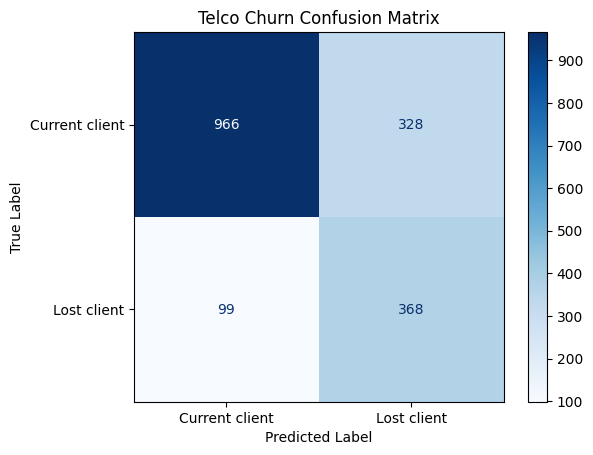

Recall: 0.7880085653104925
Precision: 0.5287356321839081
Specifity: 0.7465224111282844


In [ ]:
# Make predictions on the test set
y_pred = churn_clf_better.predict(X_test)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a ConfusionMatrixDisplay object
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                 display_labels=["Current client", "Lost client"])

# Plot the confusion matrix
cm_disp.plot(cmap='Blues')

# Add title and axis labels
plt.title('Telco Churn Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()

#print Recall and Precision:
print("Recall:",recall_score(y_test, y_pred))
print("Precision:",precision_score(y_test, y_pred))
print("Specifity:",cm[0, 0]/(cm[0, 0]+cm[0, 1]))

Recall: 0.8008565310492506
Specifity: 0.7357032457496137

'subsample': 0.85, 'scale_pos_weight': 2.77, 'reg_lambda': 1, 'reg_alpha': 0.001, 'min_child_weight': 10, 'max_depth': 3, 'learning_rate': 0.07, 'gamma': 1, 'colsample_bytree': 0.95}

In [ ]:
# define optimisation problem
optimal_param = RandomizedSearchCV(estimator=churn_clf_SMOTE,
                             param_distributions=param_grid,
                             scoring="f1",
                             verbose=3,
                             n_jobs=100,
                             cv=10)

optimal_param.fit(X_train_resampled, y_train_resampled, verbose=3,
                  eval_set=[(X_test, y_test)])

Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 620, in inner_f
 

[0]	validation_0-aucpr:0.50838
[3]	validation_0-aucpr:0.60643
[6]	validation_0-aucpr:0.63284
[9]	validation_0-aucpr:0.63124
[12]	validation_0-aucpr:0.63734
[15]	validation_0-aucpr:0.64342
[18]	validation_0-aucpr:0.64911
[21]	validation_0-aucpr:0.65321
[24]	validation_0-aucpr:0.65446
[27]	validation_0-aucpr:0.65356
[30]	validation_0-aucpr:0.65185
[33]	validation_0-aucpr:0.65130
[36]	validation_0-aucpr:0.64862


RandomizedSearchCV(cv=10,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=10,
                                           enable_categorical=False,
                                           eval_metric='aucpr',
                                           feature_types=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_ra...
                   param_distributions={'colsample_bytree': [0.3, 0, 4, 0.5,
                                                             0.6, 0.7, 0.8, 0.9,
                                                             0.95, 0.98],
                                        'gamma': [0, 0.1, 0.2, 1, 3, 5],
                                        'learning_rate': [0.001, 0.01, 0.05,
                                                          0.07, 0.1],
                                        'max_depth': [3, 4, 5, 7],
                                        'min_child_weight': [1, 3, 5, 7, 10],
                                        'reg_alpha': [0, 0.001, 0.01],
                                        'reg_lambda': [0, 0.001, 0.01, 0.1, 0.5,
                                                       1],
                                        'scale_pos_weight': [2.77],
                                        'subsample': [0.7, 0.8, 0.85, 0.87,
                                                      0.9]},
                   scoring='f1', verbose=3)

In [ ]:
print(optimal_param.best_params_)

{'subsample': 0.85, 'scale_pos_weight': 2.77, 'reg_lambda': 0.5, 'reg_alpha': 0.001, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 1, 'colsample_bytree': 0.7}


'subsample': 0.85, 'scale_pos_weight': 2.77, 'reg_lambda': 0.5, 'reg_alpha': 0.001, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 1, 'colsample_bytree': 0.7}

In [ ]:
churn_clf_better_SMOTE=xgb.XGBClassifier(objective="binary:logistic",
                             seed=5,
                              early_stopping_rounds=10,
                              learning_rate=0.1,
                              max_depth=7,
                              subsample=0.85,
                              colsample_bytree=0.7,
                            gamma=1,
                            reg_lambda=0.5,
                            scale_pos_weight=2.77,
                                   min_child_weight=5,
                                   reg_alpha=0.001
                                   , eval_metric="aucpr"
                                   )


# Fit the model as specified
churn_clf_better_SMOTE.fit(X_train_resampled, y_train_resampled,
                     verbose=3,
                     eval_set=[(X_test, y_test)]
)


[0]	validation_0-aucpr:0.50838
[3]	validation_0-aucpr:0.60643
[6]	validation_0-aucpr:0.63284
[9]	validation_0-aucpr:0.63124
[12]	validation_0-aucpr:0.63734
[15]	validation_0-aucpr:0.64342
[18]	validation_0-aucpr:0.64911
[21]	validation_0-aucpr:0.65321
[24]	validation_0-aucpr:0.65446
[27]	validation_0-aucpr:0.65356
[30]	validation_0-aucpr:0.65185
[33]	validation_0-aucpr:0.65130
[36]	validation_0-aucpr:0.64862


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

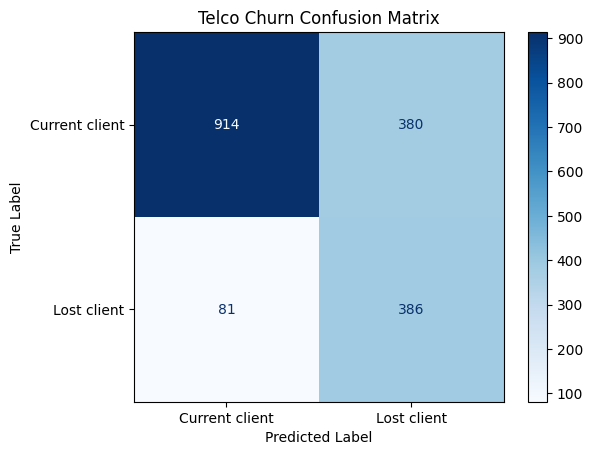

Recall: 0.8265524625267666
Precision: 0.5039164490861618
Specifity: 0.7063369397217929


In [ ]:
# Make predictions on the test set
y_pred = churn_clf_better_SMOTE.predict(X_test)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a ConfusionMatrixDisplay object
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                 display_labels=["Current client", "Lost client"])

# Plot the confusion matrix
cm_disp.plot(cmap='Blues')

# Add title and axis labels
plt.title('Telco Churn Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()

#print Recall and Precision:
print("Recall:",recall_score(y_test, y_pred))
print("Precision:",precision_score(y_test, y_pred))
print("Specifity:",cm[0, 0]/(cm[0, 0]+cm[0, 1]))